# Shelter Animals - Modelling 
In this notebook we'll be using the CSV created in the EDA and Data Preparation stages to create and compare various models. We'll start out simple and gradually move onto more complicated models.

# Table of Contents

1. [Importing Libraries and Loading Data](#chapter1)
2. [Setting a Classification Baseline](#chapter2)
3. [Very Basic Model](#chapter3)
4. [Encoding and Processing Features](#chapter4)
5. [Heatmapping the Dataframe](#chapter5)
6. [Dividing Data Into Training and Test Set](#chapter6)
7. [Scaling the Data](#chapter7)
8. [Re-usable Functions](#chapter8)
9. [Decision Tree](#chapter9)
10. [Random Forest](#chapter10)
11. [Feature Selection](#chapter11)
12. [K-Nearest Neighbors Classification](#chapter12)
13. [Support Vector Machine Classification](#chapter13)
14. [Overview of Results](#chapter14)

# 1. Importing Libaries and Loading Data <a class="anchor" id="chapter1"></a>
We will begin by importing all the libraries we're going to require and printing their versions. We'll also load in the data we prepared throughout the previous notebooks.

### 1.1 General Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import time

print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('seaborn version:', sns.__version__)
print('matplotlib version:', matplotlib.__version__)

%matplotlib inline

numpy version: 1.20.3
pandas version: 1.3.2
seaborn version: 0.11.2
matplotlib version: 3.4.2


### 1.2 Sklearn Packages

In [2]:
import sklearn as sk

# Processing Data
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.kernel_approximation import Nystroem

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# Model Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.tree import export_text

print('scikit-learn version:', sk.__version__)

scikit-learn version: 0.24.2


### 1.3 Datasheet
Lastly we'll import the datasheet we prepared in the previous notebooks.

In [3]:
df = pd.read_csv('Datasets/Austin Data Prep.csv')

# 2. Setting a Classification Baseline <a class="anchor" id="chapter2"></a>
*A baseline is a method that uses heuristics, simple summary statistics, randomness, or machine learning to create predictions for a dataset.*

We will set the baseline by finding the largest adoption speed group. If we were to always predict this group this is the percentage of correct predictions we would end up with.

In [4]:
# Divide the largest group by the total and print the result
percentage = round(df['Adoption Speed'].value_counts()[0] / len(df['Adoption Speed']) * 100, 2)
print('Baseline:', str(percentage) + '%')

Baseline: 23.53%


# 3. Very Basic Model <a class="anchor" id="chapter3"></a>
During the EDA and Data Preparation stage I set up a very simple model our of curiosity on its performance. To keep things as simple as possible a bunch of the features were discarded. Some features that are in the current model such as the intake age were not extracted yet and therefor weren't used in this model.

Because I used a label encoder as opposed to one hot encoding the features I went with a decision tree. Any models that use distance would perform significantly worse.

### Converting Dates and Timedelta
We need to convert these values in order to extract dates and/or numerical values from them.

In [5]:
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'])
df['Intake DateTime'] = pd.to_datetime(df['Intake DateTime'])

df['IntakeAge'] = pd.to_timedelta(df['IntakeAge'])
df['OutcomeAge'] = pd.to_timedelta(df['OutcomeAge'])
df['Days in Shelter'] = pd.to_timedelta(df['Days in Shelter'])

### Label Encoding Features and Extracting Dates
We'll use a function that label encodes a list of features and a function that pulls time based data out of a date. We'll then create a new dataframe that we'll use for our basic modelling.

In [6]:
le = LabelEncoder()

def label_encode(df_in, df_out, feature_names, le):
    for feature in feature_names:
        df_out[feature] = le.fit_transform(df_in[feature])

def encode_date(column, df_out):
    df_out[column.name + ' Year'] = column.dt.year
    df_out[column.name + ' Month'] = column.dt.month
    df_out[column.name + ' Week'] = column.dt.isocalendar().week
    df_out[column.name + ' Day'] = column.dt.day
    df_out[column.name + ' Weekday'] = column.dt.weekday
    
df_enc = pd.DataFrame()
features = ['Animal Type', 'Breed', 'Gender', 'Color', 'Name', 
            'Castration Intake', 'Castration Outcome','Intake Type', 'Intake Condition', 'Adoption Speed']

label_encode(df, df_enc, features, le)
encode_date(df['Date of Birth'], df_enc)
encode_date(df['Intake DateTime'], df_enc)

### Dividing Data Into Training And Test Set 
We are splitting our training into a train and test set so we can test how our model performs on data that it has not been trained on. We set the random state so it performs the exact same every time this code is run.

In [7]:
df_x = df_enc.drop('Adoption Speed',axis=1)
df_y = df_enc['Adoption Speed']
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=0)

### Training a Decision Tree Classifier
Because we used labelencoding we cannot use distance based models. To keep things simple we'll try a Decision Tree.

In [8]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=1000, min_samples_leaf=10)
decision_tree = decision_tree.fit(x_train, y_train)

decision_tree_predict = decision_tree.predict(x_test)

accuracy = metrics.accuracy_score(y_test, decision_tree_predict)
print('Accuracy:', str(round(accuracy,3)) + '%' + '\n')
print(classification_report(y_test, decision_tree_predict))

Accuracy: 0.384%

              precision    recall  f1-score   support

           0       0.45      0.50      0.48      2726
           1       0.39      0.37      0.38      1979
           2       0.32      0.33      0.32      2515
           3       0.38      0.33      0.35      1833
           4       0.37      0.35      0.36      2686

    accuracy                           0.38     11739
   macro avg       0.38      0.38      0.38     11739
weighted avg       0.38      0.38      0.38     11739



The accuracy is approximately 38%. We'd be able to get a more precise read using cross validation but will only do this in a future model. We're able to distinguish between the different classes and see that group 0 performs significantly better than the others. Precision and recall are approximately at the same levels. Group 3 has a higher precision while group 0 has a higher recall. 

### Linear Regression
We'll use the same training data to make a Linear Regression mode. One way to read the accuracy from this is using the R2 score. 

In [9]:
reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)
print('R2 Score:', str(round(r2_score(y_test, y_pred),4)))

R2 Score: 0.0337


As you can see this doesn't do a very good job. This is to be expected considering the fact that linear regression is a distance based algorithm. Looking back at this in hindsight I accidentally made use of the categories as opposed to the numerical values. 

# 4. Encoding and Processing Features <a class="anchor" id="chapter4"></a>
The label encoding we did earlier was very quick and rough. We want to begin by loading in all the features we're interested in then process them properly.

### 4.1 One Hot Encoding
We're going to encode our categorical data. One hot encoding essentially involves selecting or detecting categories you wish to save and turning each of them into a feature. A '1' gets assigned when a row matches a category and a '0' gets assigned when it doesn't. By doing this we prevent any kind of bias in our data such as one category weighing differently simply because it was assigned a higher or lower number.

<img src='https://i.imgur.com/mtimFxh.png' width=500px heigth=500px align="left">

We'll make a dataframe of a subset of our categorical data then use a OneHotEncoder from sklearn. This will allow us to one hot encode input data in the future by pickling the OneHotEncoder object. We'll do the same thing for the names. Based on our EDA we mainly saw a difference between known and unknown names. Due to the large number of names we won't one hot encode the others. 

During the Data Preparation we already one hot encoded the colors in a way that allows them to hold multiple values. We put these in a separate dataframe to merge them later.

In [10]:
column_names = ['Animal Type', 'Breed Bucket', 'Gender',
               'Intake Type', 'Intake Condition', 'Castration Intake', 'Castration Outcome']
df_model = df[column_names]

enc = OneHotEncoder(sparse=False)
transformed = enc.fit_transform(df_model)
df_ohe = pd.DataFrame(transformed)
df_ohe.columns = enc.get_feature_names(column_names)

name_enc = OneHotEncoder(categories = [['Unknown']], sparse=False, handle_unknown='ignore')
transformed_names = name_enc.fit_transform(df[['Name']])
df_names = pd.DataFrame(transformed_names, columns=['Name_Unknown'])

df_colors = df[['Tabby', 'Tricolor', 'Brown', 'Black', 'White', 'Orange', 'Tortie', 'Calico', 'Blue', 'Tan', 'Brindle']]

### 4.2 Dates and TimeDeltas
Dates and timedeltas have to be handled slightly differently. We earlier wrote a function that allows us to extract the year, month, week, day and day of the week out of a date. We'll reuse this function and extract the hour from the intake datetime. We'll convert the intake age and the days in shelter to a number of days. Although we could convert this to seconds the difference will be very small after scaling. It is also irrelevant to our result and makes the data easier to read.

In [11]:
df_dates = pd.DataFrame()
encode_date(df['Date of Birth'], df_dates)
encode_date(df['Intake DateTime'], df_dates)
df_dates['Intake DateTime Hour'] = df['Intake DateTime'].dt.hour        
df_dates['IntakeAge'] = df['IntakeAge'].dt.days
df_dates['Days in Shelter'] = df['Days in Shelter'].dt.days
df_dates

,Date of Birth Year,Date of Birth Month,Date of Birth Week,Date of Birth Day,Date of Birth Weekday,Intake DateTime Year,Intake DateTime Month,Intake DateTime Week,Intake DateTime Day,Intake DateTime Weekday,Intake DateTime Hour,IntakeAge,Days in Shelter
0,2021,4,15,15,3,2021,10,41,15,4,11,183,5
1,2020,5,21,19,1,2020,6,25,18,3,14,30,35
2,2015,10,41,11,6,2017,10,41,11,2,15,731,4
3,2015,1,2,11,6,2015,7,28,11,5,18,181,139
4,2013,2,6,4,0,2015,2,6,4,2,12,730,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58686,2020,8,34,17,0,2021,8,33,17,1,16,365,13
58687,2021,2,7,19,4,2021,7,27,6,1,15,137,17
58688,2013,10,43,27,6,2018,11,46,12,0,18,1842,42
58689,2013,10,43,27,6,2020,9,40,30,2,14,2530,226


### 4.3 Adoption Speed
Adoption speed is our main target variable. It needs to be label encoded rather than one hot encoded to keep the values in one column. The values are also logically incremental; the higher the number, the longer it took for an animal to be adopted.

In [12]:
le = LabelEncoder()
df_target = pd.DataFrame()
df_target['Adoption Speed'] = le.fit_transform(df['Adoption Speed'])

### 4.4 Merged Dataframe
We're going to merge all the smaller dataframes in one large one that will only hold numerical values. We'll use this for our machine learning models. We'll also print out all the columns to make sure they're all converted properly.

In [13]:
df_enc = pd.DataFrame()
df_enc = pd.concat([df_ohe, df_names, df_colors, df_dates, df_target], axis=1)

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df_enc)

,Animal Type_Cat,Animal Type_Dog,Breed Bucket_Border Collie,Breed Bucket_Boxer,Breed Bucket_Chihuahua,Breed Bucket_Dachshund,Breed Bucket_Domestic Longhair,Breed Bucket_Domestic Medium Hair,Breed Bucket_Domestic Shorthair,Breed Bucket_Husky,Breed Bucket_Pit Bull,Breed Bucket_Poodle,Breed Bucket_Retriever,Breed Bucket_Shepherd,Breed Bucket_Siamese Mix,Breed Bucket_Terrier,Breed Bucket_nan,Gender_Female,Gender_Male,Intake Type_Abandoned,Intake Type_Euthanasia Request,Intake Type_Owner Surrender,Intake Type_Public Assist,Intake Type_Stray,Intake Condition_Aged,Intake Condition_Behavior,Intake Condition_Feral,Intake Condition_Injured,Intake Condition_Medical,Intake Condition_Neonatal,Intake Condition_Normal,Intake Condition_Nursing,Intake Condition_Other,Intake Condition_Pregnant,Intake Condition_Sick,Castration Intake_False,Castration Intake_True,Castration Outcome_False,Castration Outcome_True,Name_Unknown,Tabby,Tricolor,Brown,Black,White,Orange,Tortie,Calico,Blue,Tan,Brindle,Date of Birth Year,Date of Birth Month,Date of Birth Week,Date of Birth Day,Date of Birth Weekday,Intake DateTime Year,Intake DateTime Month,Intake DateTime Week,Intake DateTime Day,Intake DateTime Weekday,Intake DateTime Hour,IntakeAge,Days in Shelter,Adoption Speed
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0,1,0,0,0,0,0,0,0,0,2021,4,15,15,3,2021,10,41,15,4,11,183,5,4
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,2020,5,21,19,1,2020,6,25,18,3,14,30,35,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58689,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,1,0,0,0,0,0,0,2013,10,43,27,6,2020,9,40,30,2,14,2530,226,3
58690,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,1,0,0,0,0,0,0,2013,10,43,27,6,2016,9,35,1,3,10,1040,88,3


Lastly we'll do a null check on our dataframe to make sure none of the rows having missing values.

In [14]:
df_enc[df_enc.isna().any(axis=1)]

,Animal Type_Cat,Animal Type_Dog,Breed Bucket_Border Collie,Breed Bucket_Boxer,Breed Bucket_Chihuahua,Breed Bucket_Dachshund,Breed Bucket_Domestic Longhair,Breed Bucket_Domestic Medium Hair,Breed Bucket_Domestic Shorthair,Breed Bucket_Husky,...,Date of Birth Weekday,Intake DateTime Year,Intake DateTime Month,Intake DateTime Week,Intake DateTime Day,Intake DateTime Weekday,Intake DateTime Hour,IntakeAge,Days in Shelter,Adoption Speed


# 5. Heatmapping the Dataframe <a class="anchor" id="chapter5"></a>
Heatmapping the dataframe gives us an idea which features have a direct correlation with eachother. Because the dataframe is so large we're going to split it up into 3 diffent dataframes and map them our separately. The downside is that we won't be able to see some of the correlations between the variables. We'll still see the direct correlations between the variables and our target. If these are low that isn't necessarily a problem. The heatmap won't display how good a combination of variables performs in predicting the target.

In [15]:
df_hm1 = pd.concat([df_enc.iloc[:, : 19], df_enc[['Days in Shelter', 'Adoption Speed']]], axis=1)
df_hm2 = pd.concat([df_enc.iloc[:, 19 : 40], df_enc[['Days in Shelter', 'Adoption Speed']]], axis = 1)
df_hm3 = df_enc.iloc[:, 40 : 65]

Because we're going to make 3 heatmaps we'll make a function to create one from a dataframe.

In [16]:
def create_heatmap(df):
    fig, ax = plt.subplots(figsize=(20,20))   
    ax = sns.heatmap(df.corr(method='pearson').abs(), annot=True, square=True)
    plt.rcParams.update({'font.size':8})
    return plt

We'll then make our three heatmaps

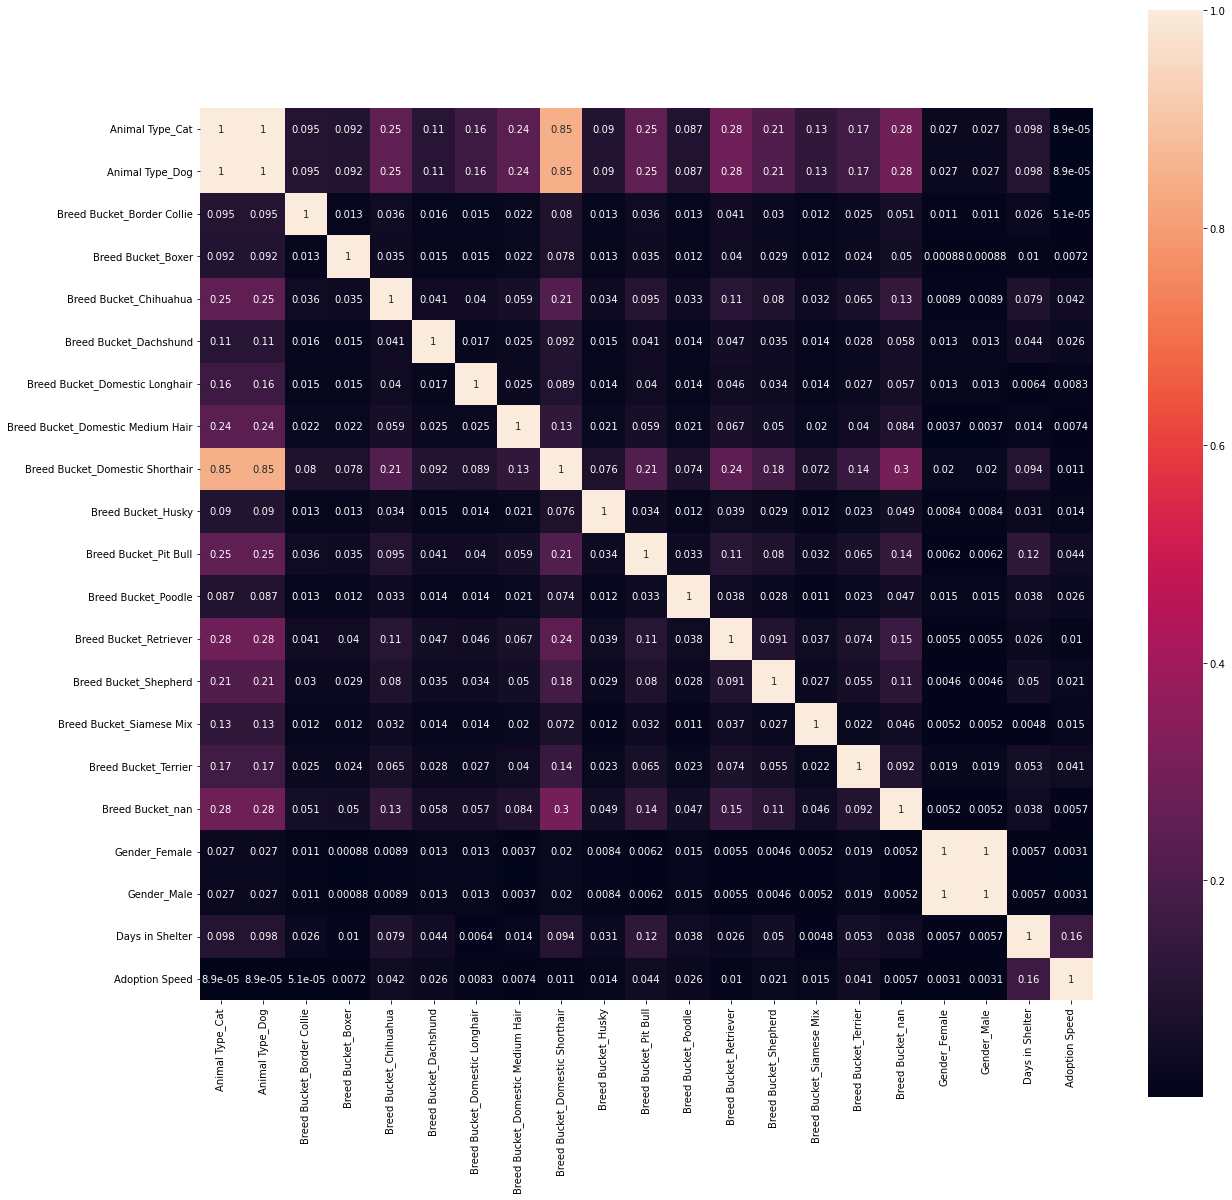

In [17]:
plt = create_heatmap(df_hm1)
plt.show()

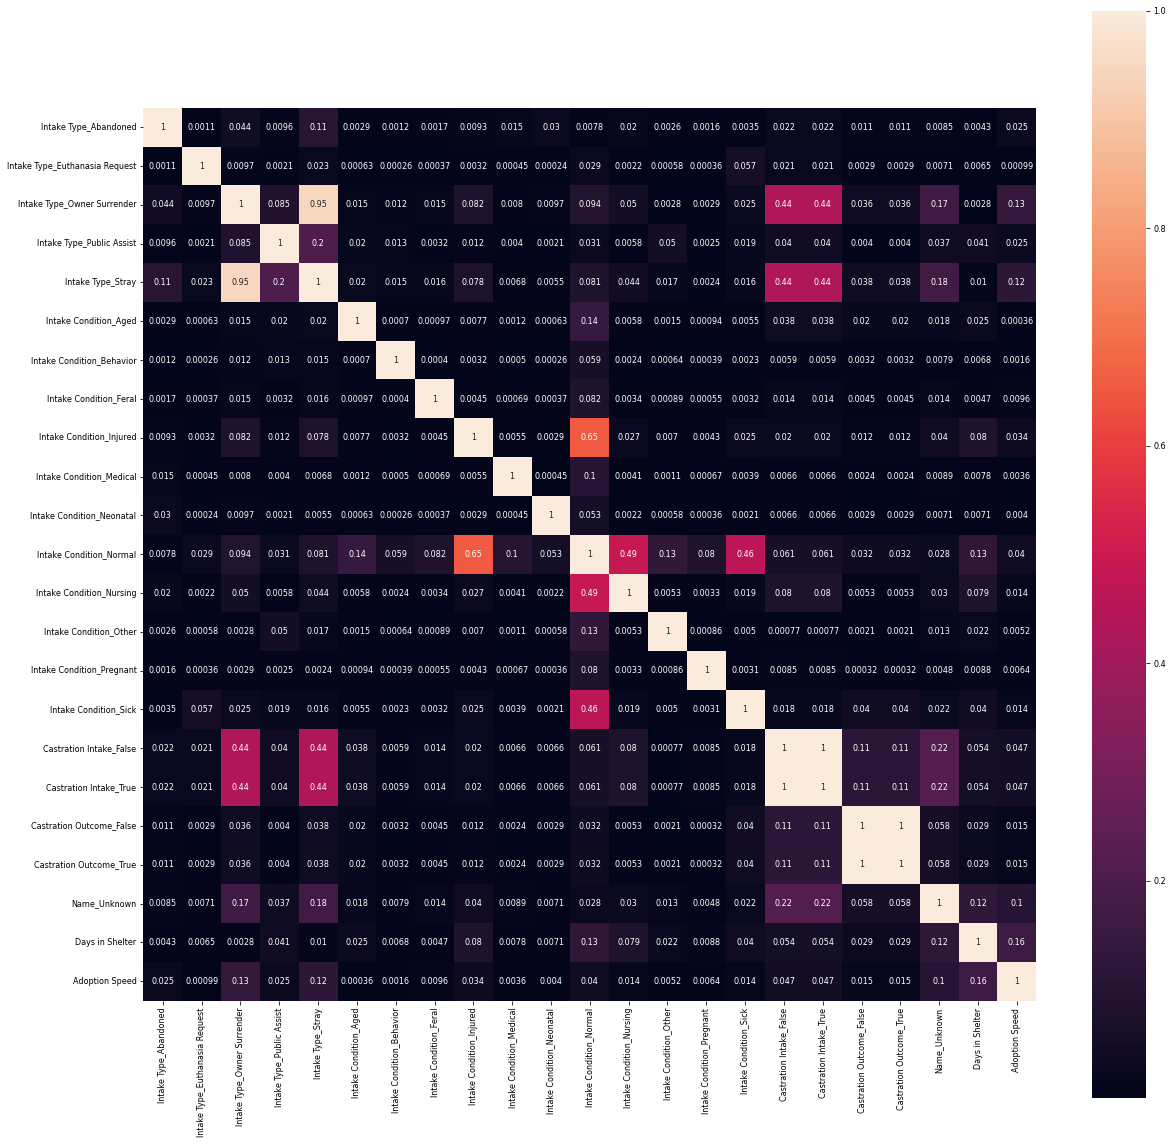

In [18]:
plt = create_heatmap(df_hm2)
plt.show()

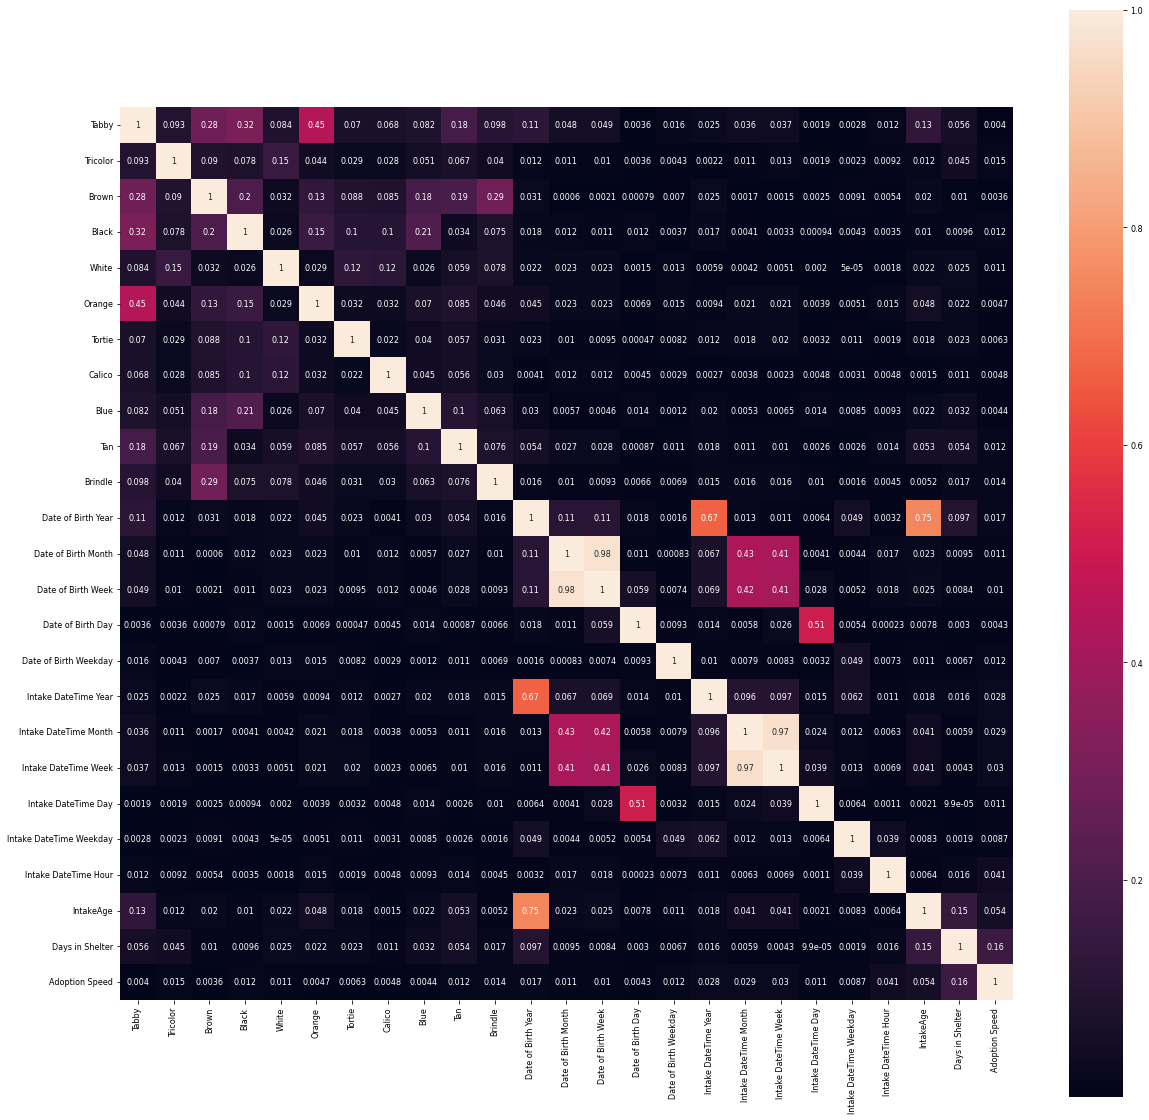

In [19]:
plt = create_heatmap(df_hm3)
plt.show()

Based on the way we one hot encoded we found some downsides. There's some values with a value of or close to 1. In the case of cat and dog we do not need two categories. If the animal is not a cat we know it's a dog as these are the only animal types that we're handling. And if an animal is male we know it's not female. Castration intake and outcome also have this issue. The result is that these categories fulfill the same function. Keeping both will put too much weight on the features.

Stray cats have a very high overlap with owner surrender of 0.95. This is due to the fact that most rows either contain one or the other, but this isn't always the case. We'll consider dropping this later.

Lastly there's a very high overlap between month and week which makes sense. We'll drop the week column considering it's inaccuracy (it sometimes counts as 53rd week, because a year is not perfectly divisible into weeks). 

In [20]:
df_enc.drop(['Animal Type_Cat', 'Gender_Male', 'Castration Intake_False', 'Castration Outcome_False'], axis=1, inplace=True)

# 6. Dividing Data Into Training and Validation Set <a class="anchor" id="chapter6"></a>
We're going to be using K-Fold Cross Validation on our training set in order to create the best models possible. Afterwards we want to evaluate the performance of this model which we'll do using our validation set. A representation of this can be seen below in an image from scikit-learn.

<img src='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png' width=500px heigth=500px align="left">

We'll begin by splitting our data in a train and validation set. We'll make a seperate set for regression. Note that because our input is the same our x training and x validation are the same assuming we use the same random state. We don't need to keep these seperate. This will both save work and memory during the following scaling steps.

In [21]:
df_X = df_enc.drop(['Days in Shelter', 'Adoption Speed'],axis=1)
df_y = df_enc['Adoption Speed']
df_y_reg = df_enc['Days in Shelter']

X_train, X_val, y_train, y_val = train_test_split(df_X, df_y, test_size=0.20, random_state=42)
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(df_X, df_y_reg, test_size=0.20, random_state=42)
X_train.head()

,Animal Type_Dog,Breed Bucket_Border Collie,Breed Bucket_Boxer,Breed Bucket_Chihuahua,Breed Bucket_Dachshund,Breed Bucket_Domestic Longhair,Breed Bucket_Domestic Medium Hair,Breed Bucket_Domestic Shorthair,Breed Bucket_Husky,Breed Bucket_Pit Bull,...,Date of Birth Week,Date of Birth Day,Date of Birth Weekday,Intake DateTime Year,Intake DateTime Month,Intake DateTime Week,Intake DateTime Day,Intake DateTime Weekday,Intake DateTime Hour,IntakeAge
17135,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,16,22,3,2021,9,36,7,1,15,138
16840,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15,14,6,2014,4,16,14,0,9,365
29116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,15,12,1,2016,5,19,12,3,17,30
15811,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,16,15,2,2018,2,7,15,3,13,1037
46620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,11,14,5,2016,3,11,14,0,13,366


# 7. Scaling the Data <a class="anchor" id="chapter7"></a>

We split the data before scaling and normalising so that the training data does not influence the validation data in any way or form. The validation set needs to play the role of unseen data. It is not meant to be accessible during the training stage and should not influence the training data in any way. If we were to use it to create a scaler this could already introduce a potential bias. We will, however, use the scaler that was created by the training data to already scale the validation data.

> *The two most popular techniques for scaling numerical data prior to modeling are normalization and standardization. Normalization scales each input variable separately to the range 0-1, which is the range for floating-point values where we have the most precision. Standardization scales each input variable separately by subtracting the mean (called centering) and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one. - machinelearningmastery.com*

Scaling of the data is important to prevent any initial bias. Is we were to not scale the data distance based algorithms such as Linear Regression, K-Nearest Neighbors and Support Vector Machines would weigh certain features more heavily than others. By scaling them down to their proportionate levels each feature is treated fairly. Although the scaling is not necessary for algorithms such as the Decision Tree and Random Forest, we're already applying it for the models that are to come after those.

<img src='https://miro.medium.com/max/2000/1*yR54MSI1jjnf2QeGtt57PA.png' width=400px heigth=400px align="left">

We'll be making use of sklearn's StandardScaler and MinMaxScaler to fulfill these needs. The benefit of this is that we can pickle the objects for deployment. We'll be making use of the MinMaxScaler where possible. One of the requirements is for us to know the minimum and maximum values possible. This isn't the case for ours years. A better way to go about time forecasting would be to use ARIMA, but we'll save that for a future iteration. We'll first define the difference in features as two groups. 

In [22]:
min_max_features = ['Date of Birth Month', 'Date of Birth Week', 'Date of Birth Day', 'Date of Birth Weekday', 
 'Intake DateTime Month', 'Intake DateTime Week', 'Intake DateTime Day', 'Intake DateTime Weekday', 'Intake DateTime Hour', 
 'IntakeAge']

standardisation_features = ['Date of Birth Year', 'Intake DateTime Year']

We can then scale each of the feature lists accordingly. Normally this causes a SettingsWithCopyWarning to come up. Because this is a false positive with temporarily disable it using a with statement. After the index the option context is set back to normal meaning SettingsWithCopyWarnings will come up again.

In [23]:
min_max_scaler = MinMaxScaler().fit(X_train[min_max_features])
standard_scaler = StandardScaler().fit(X_train[standardisation_features])

with pd.option_context('mode.chained_assignment', None): 
    X_train[min_max_features] = min_max_scaler.transform(X_train[min_max_features])
    X_train[standardisation_features] = standard_scaler.transform(X_train[standardisation_features])
    X_val[min_max_features] = min_max_scaler.transform(X_val[min_max_features])
    X_val[standardisation_features] = standard_scaler.transform(X_val[standardisation_features])
    
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(X_train)    
    display(X_val)

,Animal Type_Dog,Breed Bucket_Border Collie,Breed Bucket_Boxer,Breed Bucket_Chihuahua,Breed Bucket_Dachshund,Breed Bucket_Domestic Longhair,Breed Bucket_Domestic Medium Hair,Breed Bucket_Domestic Shorthair,Breed Bucket_Husky,Breed Bucket_Pit Bull,Breed Bucket_Poodle,Breed Bucket_Retriever,Breed Bucket_Shepherd,Breed Bucket_Siamese Mix,Breed Bucket_Terrier,Breed Bucket_nan,Gender_Female,Intake Type_Abandoned,Intake Type_Euthanasia Request,Intake Type_Owner Surrender,Intake Type_Public Assist,Intake Type_Stray,Intake Condition_Aged,Intake Condition_Behavior,Intake Condition_Feral,Intake Condition_Injured,Intake Condition_Medical,Intake Condition_Neonatal,Intake Condition_Normal,Intake Condition_Nursing,Intake Condition_Other,Intake Condition_Pregnant,Intake Condition_Sick,Castration Intake_True,Castration Outcome_True,Name_Unknown,Tabby,Tricolor,Brown,Black,White,Orange,Tortie,Calico,Blue,Tan,Brindle,Date of Birth Year,Date of Birth Month,Date of Birth Week,Date of Birth Day,Date of Birth Weekday,Intake DateTime Year,Intake DateTime Month,Intake DateTime Week,Intake DateTime Day,Intake DateTime Weekday,Intake DateTime Hour,IntakeAge
17135,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0,0,0,0,0,1,0,0,0,1.626101,0.272727,0.288462,0.700000,0.5,1.729415,0.727273,0.673077,0.200000,0.166667,0.652174,0.019885
16840,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0,0,0,0,0,0,1,0,-0.744388,0.272727,0.269231,0.433333,1.0,-1.416685,0.272727,0.288462,0.433333,0.000000,0.391304,0.052594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15795,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,1,0,0,0,0,0,0,0,-0.448077,1.000000,0.000000,0.933333,0.0,0.830529,1.000000,0.980769,0.933333,1.000000,0.739130,0.263112
56422,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0,1,0,0,0,0,0,0,0.440857,0.000000,0.000000,0.233333,1.0,1.279972,0.000000,0.076923,0.966667,0.500000,0.521739,0.160951


,Animal Type_Dog,Breed Bucket_Border Collie,Breed Bucket_Boxer,Breed Bucket_Chihuahua,Breed Bucket_Dachshund,Breed Bucket_Domestic Longhair,Breed Bucket_Domestic Medium Hair,Breed Bucket_Domestic Shorthair,Breed Bucket_Husky,Breed Bucket_Pit Bull,Breed Bucket_Poodle,Breed Bucket_Retriever,Breed Bucket_Shepherd,Breed Bucket_Siamese Mix,Breed Bucket_Terrier,Breed Bucket_nan,Gender_Female,Intake Type_Abandoned,Intake Type_Euthanasia Request,Intake Type_Owner Surrender,Intake Type_Public Assist,Intake Type_Stray,Intake Condition_Aged,Intake Condition_Behavior,Intake Condition_Feral,Intake Condition_Injured,Intake Condition_Medical,Intake Condition_Neonatal,Intake Condition_Normal,Intake Condition_Nursing,Intake Condition_Other,Intake Condition_Pregnant,Intake Condition_Sick,Castration Intake_True,Castration Outcome_True,Name_Unknown,Tabby,Tricolor,Brown,Black,White,Orange,Tortie,Calico,Blue,Tan,Brindle,Date of Birth Year,Date of Birth Month,Date of Birth Week,Date of Birth Day,Date of Birth Weekday,Intake DateTime Year,Intake DateTime Month,Intake DateTime Week,Intake DateTime Day,Intake DateTime Weekday,Intake DateTime Hour,IntakeAge
58178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,1,0,0,-0.151765,0.454545,0.423077,0.000000,0.000000,-0.967242,0.636364,0.576923,0.000000,0.833333,0.695652,0.008790
22377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,1,0,1,0,0,0,0,0,0,0.144546,0.272727,0.250000,0.300000,1.000000,-0.517799,0.363636,0.346154,0.300000,0.166667,0.608696,0.004323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36419,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,1,0,0,0,0,0,0,0,0,-0.151765,0.454545,0.442308,0.400000,0.833333,-0.967242,0.545455,0.519231,0.333333,0.833333,0.478261,0.004035
34726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1,1,0,0,0,0,0,0,1.033479,0.272727,0.269231,0.266667,0.166667,0.830529,0.363636,0.365385,0.500000,0.500000,0.695652,0.005331


All values are now scaled to their respective ranges. The year feature has a larger than than the others which potentially could cause it to carry too much weight. We'll see if this is an issue as we progress further.

# 8. Re-usable Functions <a class="anchor" id="chapter8"></a>
Considering we're printing the accuracy so often we'll make a function to convert it from a decimal number to an actual percentage. We'll also make a function to print it out as well as a function to print it in combination with the evaluation matrix. Another benefit of these functions is that we won't have to store a bunch of objects in memory that we'll only be using once.

In [24]:
# Define constant variables
train_string = 'Accuracy on training set:'
cv_score_string = 'Cross Validation Scores: \n'
cv_mean_string = 'Cross Validation Mean:'

# Convert value to percentage and return it as string
def get_accuracy(value):
    return str(round(value * 100,2)) + '%'

# Print the accuracy
def print_accuracy(message, value):
    accuracy = get_accuracy(value)
    print(message, accuracy)
    
# Print the cross validation results
def print_cv(cv_scores):
    print(cv_score_string, str(cv_scores) + '\n')
    print_accuracy(cv_mean_string, cv_scores.mean())

# Print the accuracy with classification report
def print_class_report(y_true, y_pred):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    print_accuracy('Accuracy:', accuracy)
    print('\n' + classification_report(y_true, y_pred))

# 9. Decision Tree <a class="anchor" id="chapter9"></a>
We're going to begin by making another decision tree. Rather than trying to find its hyperparameters using GridSearch we're simply going to make a guess. We'll look for the optimal parameters later. After creating and fitting the model we'll score it on the training data.

In [25]:
# Create the Decision Tree and fit the model to our data
dt_model = DecisionTreeClassifier(max_depth = 30, min_samples_leaf=3, random_state=42)
dt_clf = dt_model.fit(X_train, y_train) 

# Print the accuracy on the training set
dt_accuracy = dt_clf.score(X_train, y_train)
print_accuracy(train_string, dt_accuracy)

Accuracy on training set: 79.87%


### 9.1 Cross Validation
While the model performed decent on its training data we're much more interested in how it performs on testing data. For this we're going to use K-Fold Cross Validation. But what number do we pick for K? In practise people tend to use 5-, 10- or 20-fold CVs. The higher number of K the less biased our results will be, but the costlier our evaluation will be. Especially in the case of GridSearch the amount of time would increase very quickly as we'd be running many evaluations. 

In [26]:
# Retrain the decision tree model using cross validation as testing method
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=10, scoring='accuracy') 

# Print the scores and average score
print_cv(cv_scores)

Cross Validation Scores: 
 [0.41482112 0.42291312 0.41853035 0.41192758 0.41299255 0.42321619
 0.41810437 0.42513312 0.42428115 0.43535676]

Cross Validation Mean: 42.07%


### 9.2 Evaluation on Validation Set
While the cross validation on the test set performs somewhat okay the real test is the validation set. This is unseen data and gives the best measure of how well the model actually performs. Here we can see that the model performs quite similarly to the cross validation mean.

In [27]:
# Predict the values of our validation set
predict = dt_clf.predict(X_val)

# Print the accuracy of our prediction
print_class_report(y_val, predict)

Accuracy: 42.57%

              precision    recall  f1-score   support

           0       0.48      0.55      0.51      2731
           1       0.43      0.45      0.44      1926
           2       0.36      0.35      0.36      2497
           3       0.46      0.42      0.44      1805
           4       0.40      0.36      0.38      2780

    accuracy                           0.43     11739
   macro avg       0.43      0.43      0.42     11739
weighted avg       0.42      0.43      0.42     11739



What's interesting to see is that the first class, while regrouped in comparison to chapter 3, still performs the best. This makes sense as young animals are adopted quickly, making it easier to predict the younger animals are.

### 9.3 Grid Search
We can use Grid Search to tune the hyperparameters of our decision tree. There's a couple ways to go about this. We can give it a large number of hyperparameters which will be multiplied into the number of iterations. The more hyperparameters we give it to try, the longer it will take to compute which model is the best. I gave it a large number of hyperparameters to try overnight. A better way of doing this would be selecting multitudes of 5 or 10, then doing another set close to the values found.

I later selected a smaller iteration of 2 x 5 x 4 x 5 = 200 combinations. We're using 5 crossfolds meaning each combination is created and tested 5 times on different portions of the model, resulting in a total of 1000 fits. 

In [28]:
# Hyperparameters that we want to tune first iteration
# criterion = ['gini', 'entropy']
# max_depth = np.arange(1,31)
# min_samples_split = np.arange(2,11)
# min_samples_leaf = np.arange(1,10)

# Hyperparameters that we want to tune smaller sample (same results)
criterion = ['gini', 'entropy']
max_depth = np.arange(8,13)
min_samples_split = np.arange(2,6)
min_samples_leaf = np.arange(1,6)

# Create Dictionary of Hyperparameters
param_grid = [
    {
        'criterion': criterion, 
         'max_depth': max_depth,
         'min_samples_split': min_samples_split, 
         'min_samples_leaf': min_samples_leaf, 
    }
]

dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, return_train_score=True, verbose=0, n_jobs=-1)

We can now fit the training data to our Grid Search. This will train our model and evaluate it using cross validation. We can look up the best parameters that are found, the accuracy it found on the best set and a number of other features.

In [29]:
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': array([ 8,  9, 10, 11, 12]),
                          'min_samples_leaf': array([1, 2, 3, 4, 5]),
                          'min_samples_split': array([2, 3, 4, 5])}],
             return_train_score=True)

### 9.3.1 Reading GridSearch Results

After fitting the data the results are printed at the very bottom. We can also find the best parameters as done below.

In [30]:
print(dt_grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4}


We can use these in the future to (re)build our model or tune it further, should we want to do so. While having the optimal parameters is great, it doesn't mean much until we know how much better the model is. Let's see how well it performs compared to the previous one.

In [31]:
# Print the accuracy the training set and cross validation results
score = dt_grid_search.score(X_train, y_train)
print_accuracy(train_string, score)
print()

# Retrain the decision tree model using cross validation as testing method and print the result
dt_grid_search_clf = DecisionTreeClassifier(random_state=42, max_depth=9, min_samples_split=4)
cv_scores = cross_val_score(dt_grid_search_clf, X_train, y_train, cv=10, scoring='accuracy') 
print_cv(cv_scores)

Accuracy on training set: 47.67%

Cross Validation Scores: 
 [0.4471891  0.44548552 0.45111821 0.44898829 0.45452609 0.45601704
 0.44813632 0.44046858 0.45835996 0.45197018]

Cross Validation Mean: 45.02%


While it performs a lot worse on the training set the accuracy on the testing set is a lot better. This is because the model is now less overfitted than it was before. We can also see how well the model performs on the validation set. This is more of a 'real' test as it uses completely unseen data.

In [32]:
print_class_report(y_val, dt_grid_search.predict(X_val))

Accuracy: 44.92%

              precision    recall  f1-score   support

           0       0.50      0.62      0.55      2731
           1       0.57      0.38      0.45      1926
           2       0.36      0.32      0.34      2497
           3       0.44      0.38      0.41      1805
           4       0.41      0.50      0.45      2780

    accuracy                           0.45     11739
   macro avg       0.46      0.44      0.44     11739
weighted avg       0.45      0.45      0.44     11739



The accuracy has improved significantly by 3%. While group 0 still does the best something interesting has happened to the precision and recall. In the first group the recall is quite high meaning the amount of false negatives was relatively low. Group 1 in comparison had relatively more false negatives, but the percentage of false positives was the lowest of all groups.

### 9.4 Evaluating Featurs
A huge benefit of using the Decision Tree model is that we can evaluate the importance of the features. Based on how often features were used to classify results and on how much weight they carried the features are given a score. We can pull the scores from the best result we found during GridSearch and print the values by combining the values with the column names.

In [33]:
# Create Series from Grid Search results and match these with column names
important_features = pd.Series(data=dt_grid_search.best_estimator_.feature_importances_,index=X_train.columns)

# Print out the results in descending order of importance
important_features.sort_values(ascending=False,inplace=True)
important_features

IntakeAge                            0.479822
Name_Unknown                         0.112125
Animal Type_Dog                      0.073483
Intake Type_Owner Surrender          0.056301
Intake DateTime Week                 0.033233
Breed Bucket_Pit Bull                0.027683
Intake Condition_Normal              0.027400
Date of Birth Year                   0.023308
Intake DateTime Year                 0.023048
Intake DateTime Day                  0.016118
Intake DateTime Hour                 0.014732
Date of Birth Day                    0.013656
Breed Bucket_Domestic Shorthair      0.012281
Date of Birth Week                   0.011155
Castration Outcome_True              0.010189
Intake DateTime Weekday              0.009233
Date of Birth Weekday                0.008018
Breed Bucket_Chihuahua               0.007620
Castration Intake_True               0.007218
Intake DateTime Month                0.003975
Intake Type_Public Assist            0.003544
Breed Bucket_Retriever            

### 9.5 Feature Selection
As we can see above a lot of the features weren't very important. Many even had a weight of 0. We can use this information to drop the worst features. In fact, we'll find that we can achieve a similar accuracy while dropping the bottom 20 features. This has the upside of being computational less intensive and faster. We're also dropping 'Day' features because I don't imagine they have a realistic impact based on domain understanding. Should we want to we could compare the accuracy with and without them to see it's better to drop them.

In [34]:
# Get the 30 worst features and add the day features to them
bad_features = important_features.tail(30).index
day_features = ['Intake DateTime Day', 'Intake DateTime Weekday', 'Date of Birth Day', 'Date of Birth Weekday']
bad_features = bad_features.values.tolist() + day_features

# Create a new dataframe without these features
X_train_sub = X_train.drop(bad_features, axis=1)

# Retrain our model on the smaller dataframe
dt_model_sub = dt_grid_search.best_estimator_
dt_clf_sub = dt_model_sub.fit(X_train_sub, y_train) 

# Printing the accuracy of the training set
score = dt_clf_sub.score(X_train_sub, y_train)
print_accuracy(train_string, score)

# Cross validate the model and print the scores and mean
cv_scores = cross_val_score(dt_model_sub, X_train_sub, y_train, cv=10, scoring='accuracy')
print_cv(cv_scores)

Accuracy on training set: 47.28%
Cross Validation Scores: 
 [0.44974446 0.44591141 0.45324814 0.44430245 0.44877529 0.45644302
 0.44430245 0.43812567 0.45580405 0.45005325]

Cross Validation Mean: 44.87%


We can also see how it performs on the validation set. While dropping approximately a third of the columns we've actually gained a tiny bit of accuracy. We can continue to drop more while only losing a little bit of accuracy as well if we would want to. In order to evaluate the validation set it is important we drop the same features.

In [35]:
# Use the new model to predict the values from the validation set
predict = dt_clf_sub.predict(X_val.drop(bad_features, axis=1))

# Print out the results of our prediction
print_class_report(y_val, predict)

Accuracy: 45.16%

              precision    recall  f1-score   support

           0       0.51      0.64      0.57      2731
           1       0.57      0.39      0.47      1926
           2       0.36      0.33      0.35      2497
           3       0.45      0.37      0.40      1805
           4       0.41      0.47      0.44      2780

    accuracy                           0.45     11739
   macro avg       0.46      0.44      0.44     11739
weighted avg       0.45      0.45      0.45     11739



# 10. Random Forest <a class="anchor" id="chapter10"></a>
As mentioned in the proposal we want to try a number of models to compare their performance. One model might be better at making this prediction than another. We can theorise that SVMs will do really well, but won't know for sure until we've compared them to our other options.

A Random Forest is a collection of Decision Trees. While a Decision Tree is built on the entire dataset Random Forest randomly selects rows and features to build multiple Decision Trees. A large number of trees "votes" and the outcome that receives the most "votes" is then predicted. Considering we just tried to use a Decision Tree it seems only logical to follow it up with a Random Forest model. It's not necessarily the most common node that is chosen but rather the most common class.

<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png' width=500px heigth=500px align="left">

In [36]:
# Create a Random Forest model and fit it to our training set
rf_model = RandomForestClassifier(max_depth=10, random_state=42)
rf_clf = rf_model.fit(X_train, y_train)

# Print the accuracy on the training set
rf_accuracy = rf_clf.score(X_train, y_train)
print_accuracy(train_string, rf_accuracy)

Accuracy on training set: 50.4%


### 10.1 Cross Validation
While the model didn't do too well on the training, we mostly care on its performance on the testing data. It starts out with a cross validation accuracy of 45% which isn't too bad for a model which hasn't had its hyperparamaters tuned. We're sticking to 5 crossfolds here because the Random Forest model takes a little longer to train and validate than the Decision Tree.

In [37]:
# Cross validate our random forest model
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Print out the results from the cross validation 
print_cv(cv_scores)

Cross Validation Scores: 
 [0.4516026  0.45756575 0.45090522 0.44994675 0.45463259]

Cross Validation Mean: 45.29%


### 10.2 Evaluation on Validation Set
Once again the validation set is the real test as it uses fully unseen data. We don't expect too good of a performance yet without the hyperparameters being tuned. The accuracy of 45% is therefor really good to start out with.

In [38]:
# Use the new model to predict the values from the validation set
predict = rf_clf.predict(X_val)

# Print out the results of our prediction
print_class_report(y_val, predict)

Accuracy: 45.22%

              precision    recall  f1-score   support

           0       0.50      0.63      0.56      2731
           1       0.55      0.43      0.48      1926
           2       0.35      0.35      0.35      2497
           3       0.57      0.24      0.34      1805
           4       0.41      0.52      0.46      2780

    accuracy                           0.45     11739
   macro avg       0.48      0.43      0.44     11739
weighted avg       0.47      0.45      0.44     11739



What's particularly interesting to me here is the high precision but low recall in group 3. This group has otherwise been very stable. The results in group 4 have both increased quite a bit as well.

### 10.3 Randomised Search
Another way of tuning the hyperparameters is to use Randomised Search as opposed to GridSearch. Randomised search will pick a given number of random combinations of the hyperparameters we give it to try. Based on the best found combinations we can then do a smaller GridSearch to find a close to ideal combination. Because we're not trying as many combinations this saves a lot of computational time.


<img src='https://www.researchgate.net/profile/Karl-Ezra-Pilario/publication/341691661/figure/fig2/AS:896464364507139@1590745168758/Comparison-between-a-grid-search-and-b-random-search-for-hyper-parameter-tuning-The.png' width=500px heigth=500px align="left">


Based on the data in this [article](https://arxiv.org/abs/1705.05654) the number of trees should not be tuned. While the accuracy should increase with a higher number of trees the model won't get overfitted. During our tuning we'll keep it at its default value of 100. Setting the number higher increase computational time very rapidly and makes the Random Search take too long. We can set it to a higher value later and see how this affects our accuracy.

In [39]:
# List Hyperparameters that we want to tune
max_depth = list(range(10,110,10))
max_features = ['auto', 'sqrt']
min_samples_split = [3, 6, 9, 12]
min_samples_leaf = [1, 3, 6, 9]
bootstrap = [True, False]

# Create Dictionary of Hyperparameters
rf_param_grid = [
    {
         'max_depth': max_depth,
         'max_features': max_features, 
         'min_samples_split': min_samples_split, 
         'min_samples_leaf': min_samples_leaf, 
         'bootstrap': bootstrap
    }
]

Random search is different from GridSearch in the sense that you need to set the amount iterations you want it to run. GridSearch simply tries every combination possible while Randomised Search tries a random number of possible combinations. We make use of randomised search because Random Forest models take a lot longer to train. Because of this we're also limiting our number of cross folds to 3. When we're doing our final evaluation we can reduce this number, but for our randomised search it will take up too much computational time.

In [40]:
random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                                   rf_param_grid, 
                                   cv=3, 
                                   return_train_score=True, 
                                   verbose=0,
                                   n_jobs=-1,
                                   random_state=42,
                                   n_iter = 100)

random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'max_depth': [10, 20, 30, 40, 50, 60,
                                                       70, 80, 90, 100],
                                         'max_features': ['auto', 'sqrt'],
                                         'min_samples_leaf': [1, 3, 6, 9],
                                         'min_samples_split': [3, 6, 9, 12]}],
                   random_state=42, return_train_score=True)

Now there's a few downsides to this. Because of the large amount of features we're using it takes a really long time to get the best result. We're also not sure if the best result is actually the best result possible. Even if we now explore the parameters near the best result, we might not find the best result possible.

### 10.3.1 Improving Random Search Results
Using the random search results we can do a grid search to find the best nearby results. Again, this will take a good while due to the large number of parameters. We'll first take the best parameters and then try out other results that come close.

In [41]:
random_search_rf.best_params_

{'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [42]:
# List Hyperparameters that we want to tune
max_depth = [38,39,40,41,42]
max_features = ['auto', 'sqrt']
min_samples_split = [4,5,6,7,8]
min_samples_leaf = [1, 2, 3]
bootstrap = [True, False]

# Create Dictionary of Hyperparameters
param_grid = [
    {
         'max_depth': max_depth,
         'max_features': max_features, 
         'min_samples_split': min_samples_split, 
         'min_samples_leaf': min_samples_leaf, 
         'bootstrap': bootstrap
    }
]
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), 
                           param_grid, cv=3, return_train_score=True, verbose=0, n_jobs=-1)

In [43]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [38, 39, 40, 41, 42],
                          'max_features': ['auto', 'sqrt'],
                          'min_samples_leaf': [1, 2, 3],
                          'min_samples_split': [4, 5, 6, 7, 8]}],
             return_train_score=True)

### 10.3.2 Evaluation Random Forest
When we evaluate the models the results are interesting. The results on the training data is very good, which makes sense due to the nature of the Random Forest Model. The results of the cross validation are still very good though. While our previous best score was around 45%, we now found one of 49% which is a significant improvement.

In [44]:
# Print the accuracy the training set and cross validation results
score = random_search_rf.score(X_train, y_train)
print_accuracy(train_string, score)
print()

# Retrain the decision tree model using cross validation as testing method and print the result
rf_random_search_clf = RandomForestClassifier(max_depth=40, min_samples_split=6, bootstrap=False, random_state=42)
cv_scores = cross_val_score(rf_random_search_clf, X_train, y_train, cv=5, scoring='accuracy') 
print_cv(cv_scores)

Accuracy on training set: 98.83%

Cross Validation Scores: 
 [0.49515494 0.49355766 0.49808307 0.48977636 0.50457934]

Cross Validation Mean: 49.62%


In [45]:
score = grid_search_rf.score(X_train, y_train)
print_accuracy(train_string, score)
print()

# Retrain the decision tree model using cross validation as testing method and print the result
rf_grid_search_clf = RandomForestClassifier(max_depth=42, min_samples_split=7, bootstrap=False, random_state=42)
cv_scores = cross_val_score(rf_grid_search_clf, X_train, y_train, cv=5, scoring='accuracy') 
print_cv(cv_scores)

Accuracy on training set: 98.67%

Cross Validation Scores: 
 [0.49419657 0.49568736 0.49414271 0.49179979 0.50106496]

Cross Validation Mean: 49.54%


The grid search was not particularly helpful. The accuracy actually decreased slightly. The main factors here would be the number of trees used. This also reflects when we do our evaluation on the validation set. The GridSearch actually lowered the accuracy a tiny bit.

In [46]:
predict = random_search_rf.predict(X_val)
print_class_report(y_val, predict)

Accuracy: 50.65%

              precision    recall  f1-score   support

           0       0.56      0.66      0.61      2731
           1       0.61      0.47      0.53      1926
           2       0.41      0.43      0.42      2497
           3       0.55      0.49      0.52      1805
           4       0.46      0.47      0.47      2780

    accuracy                           0.51     11739
   macro avg       0.52      0.50      0.51     11739
weighted avg       0.51      0.51      0.51     11739



In [47]:
predict = grid_search_rf.predict(X_val)
print_class_report(y_val, predict)

Accuracy: 50.41%

              precision    recall  f1-score   support

           0       0.56      0.66      0.61      2731
           1       0.60      0.47      0.53      1926
           2       0.40      0.43      0.41      2497
           3       0.54      0.47      0.50      1805
           4       0.46      0.47      0.47      2780

    accuracy                           0.50     11739
   macro avg       0.51      0.50      0.50     11739
weighted avg       0.51      0.50      0.50     11739



### 10.3.3 Increasing the Number of Trees
One of the most important features in terms of accuracy will be the number of trees. We purposely chose a relatively low number (100) for our GridSearch in order to save time. Let's see what happens when we increase this number to 1000. I found that the min_samples_split and bootstrap were better to be the default value than the one found during the gridsearch.

In [48]:
# List Hyperparameters that we want to use
params = grid_search_rf.best_params_

rf_model_large = RandomForestClassifier(
    n_estimators=1000, 
    max_depth = params['max_depth'],
    max_features = params['max_features'],
    min_samples_leaf = params['min_samples_leaf'],
    random_state=42)
rf_clf_large = rf_model_large.fit(X_train, y_train)

In [49]:
score = rf_clf_large.score(X_train, y_train)
print_accuracy(train_string, score)

predict = rf_clf_large.predict(X_val)
print_class_report(y_val, predict)

Accuracy on training set: 99.17%
Accuracy: 51.0%

              precision    recall  f1-score   support

           0       0.56      0.67      0.61      2731
           1       0.60      0.46      0.52      1926
           2       0.41      0.43      0.42      2497
           3       0.55      0.47      0.51      1805
           4       0.47      0.48      0.48      2780

    accuracy                           0.51     11739
   macro avg       0.52      0.50      0.51     11739
weighted avg       0.51      0.51      0.51     11739



In [51]:
cv_scores = cross_val_score(rf_clf_large, X_train, y_train, cv=5, scoring='accuracy') 
print_cv(cv_scores)

Cross Validation Scores: 
 [0.49771057 0.49856245 0.49669862 0.49371672 0.50628328]

Cross Validation Mean: 49.86%


### 10.4 Dropping Features
While we would like to train a new Random Forest model the training time is currently just way too high to do any good evaluation. The results we got aren't completely useless though. We can have a look at the feature importance, compare them with the feature importance we got from the Decision Tree and use the knowledge gathered from Domain Understanding. By combining this knowledge we reduce the features and exponentially increase the training speed.

In [52]:
# Create Series from Random Search results and match these with column names
rf_important_features = pd.Series(data=random_search_rf.best_estimator_.feature_importances_,index=X_train.columns)

# Print out the results in descending order of importance
rf_important_features.sort_values(ascending=False,inplace=True)
rf_important_features

IntakeAge                            0.165261
Intake DateTime Day                  0.063626
Date of Birth Day                    0.062785
Intake DateTime Week                 0.062521
Date of Birth Week                   0.059771
Intake DateTime Hour                 0.053926
Date of Birth Year                   0.050804
Intake DateTime Year                 0.045123
Date of Birth Weekday                0.044189
Intake DateTime Weekday              0.044060
Intake DateTime Month                0.040394
Date of Birth Month                  0.039407
Name_Unknown                         0.031214
Animal Type_Dog                      0.019121
White                                0.014469
Gender_Female                        0.014461
Black                                0.012800
Brown                                0.011864
Breed Bucket_Domestic Shorthair      0.011248
Intake Type_Owner Surrender          0.010763
Intake Condition_Normal              0.010426
Breed Bucket_Pit Bull             

These results aren't as clear as the ones we got from the Decision Tree. In fact a lot of most important features we found here were Date related. We're going to drop the same features we dropped for the Decision Tree. We'll then rebuild the model and re-evaluate the results to see if they've improved.

In [53]:
# Fit the Best Grid Search Result To Subset
rf_clf_sub = rf_model_large.fit(X_train_sub, y_train) 

# Print the accuracy on the training set
score = rf_clf_sub.score(X_train_sub, y_train)
print_accuracy(train_string, score)

# Print the results of the cross validation
cv_scores = cross_val_score(rf_model_large, X_train_sub, y_train, cv=3, scoring='accuracy')
print_cv(cv_scores)

Accuracy on training set: 98.47%
Cross Validation Scores: 
 [0.47734969 0.47600792 0.47597444]

Cross Validation Mean: 47.64%


The accuracy is somewhat disappointing and has actually gone down quite a bit. This could be due to the fact that we dropped the bad features from the Decision Tree as opposed to the Random Forest, although many overlapped. Even so, a decrease of 3.5% while only using half the features isn't terribly bad. While we could likely improve this using another extensive search I'm going to choose to move on. We can take the knowledge from the Decision Tree and Random Search to do some feature selection. This will come in handy when we try out distant based algorithms as it will significantly reduce their training times.

# 11. Feature Selection <a class="anchor" id="chapter11"></a>
It seems strange to be doing feature selection after the creation of two models. While the Exploratory Data Analysis gave us a decent insight in which factors would be important, I wanted to gain more insight using feature importance. With this extra knowledge we're going to decrease our number of features.

<img src='https://miro.medium.com/max/694/0*gz5XuPZfN0wAi66I' width=350px heigth=350px align="left">

### 11.1 Feature Conclusions

Having a look at the feature importance we can gather some information. Most of this matches what we expected to see based on the Exploratory Data Analysis. We'll begin by listing the features that seemed to positively affect our prediction. 

- Age is the most important feature by far. 
- A name being unknown effects causes the adoption speed to be lower.
- Dogs and cats are adopted at different rates. 
- Animals that were surrendered are adopted slower.
- Pit bulls are generally adopted slower than other dogs.
- Some intake condition play a decent role in how fast an animal was adopted.
- While 'Date of Birth Year' references the adoption trend over the year, 'Intake DateTime Year' does so better. While using ARIMA would be better we're choosing to keep it simple for now.
- Breeds are adopted at different speeds, but some breeds don't influence the outcome (much).
- Castration Outcome causes a very small, almost negligible difference.
- Intake DateTimes somehow seem relevant. This could just be coincidences being used as a fake 'link'. We did not go in depth into this feature in the EDA as it did not appear important, but this might be worth doing in a future iteration. 

There were also a number of features that showed a clear lack of importance. Our EDA often shows us the reason why. If nothing else these features should be dropped both to save computational time in future models and to make them more accurate.
- A lot of Intake Conditions are not relevant due to the lack of data. Pregnant, Behavior, Feral, Medical, Other, Neonatal and Aged can be discarded for this reason. 
- Euthanasia Request as Intake Type did not seem to influence the outcome by much.
- A lot of colors don't appear to influence the outcome. Although there was a fair amount of animals in every color this did not seem to influence the adoption speed much. It could also be that something else, such as the extraction of colors, should have been done differently.

### 11.2 Grouping Bad Features
We're going to group bad features together. This will allow us to create a new dataframe that does or does not contain some of these groups very easily by running the code from here and below. We'll create a K Nearest Neighbour model to see the differences. Of course the ideal features could differ depending on the model, but for simplicity sake we'll test it on only one.

In [54]:
# List groups of bad features that can be removed from the dataframe
bad_intakes = ['Intake Condition_Aged',  'Intake Condition_Neonatal', 'Intake Condition_Medical', 
'Intake Condition_Feral', 'Intake Condition_Other', 'Intake Condition_Behavior', 'Intake Condition_Pregnant',
'Intake Type_Euthanasia Request']

bad_breeds = ['Breed Bucket_Poodle', 'Breed Bucket_Border Collie',  'Breed Bucket_Boxer', 'Breed Bucket_Shepherd', 
              'Breed Bucket_Siamese Mix', 'Breed Bucket_Domestic Medium Hair', 'Breed Bucket_Dachshund', 'Breed Bucket_Husky']

bad_colors = ['Calico', 'Tan', 'Orange', 'Tabby', 'Brindle', 'Tortie']
    
dates = ['Intake DateTime Year', 'Intake DateTime Month', 'Intake DateTime Week', 
         'Intake DateTime Day', 'Intake DateTime Weekday', 'Intake DateTime Hour',
        'Date of Birth Year', 'Date of Birth Month', 'Date of Birth Day', 'Date of Birth Weekday', 'Date of Birth Week']

small_dates = ['Intake DateTime Day', 'Intake DateTime Weekday', 'Intake DateTime Week', 'Intake DateTime Hour',
       'Date of Birth Day', 'Date of Birth Weekday', 'Date of Birth Week']


# Sum the groups together
dropped_columns = bad_intakes + bad_colors + bad_breeds + dates

# Create a new dataframe without said groups
X_train_fs = X_train.drop(dropped_columns, axis=1)
X_val_fs = X_val.drop(dropped_columns, axis=1)

# 12. K-Nearest Neighbors Classification <a class="anchor" id="chapter12"></a>

*K-nearest neighbors (KNN) can be used for both regression and classification. It tries to predict the correct class for the test data by calculating the distance between the test data and all the training points. It then selects the K number of points which are closet to the test data.*  

We'll be using K-Nearest Neighbour in classification format to see how a distance based algorithm does for our use case. My prediction and hope is that the results will be better than a Decision Tree, considering it's relatively complex.

In [55]:
# Create the KNN model and fit it to our data
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_clf = knn_model.fit(X_train_fs, y_train)

# Print the accuracy on the training set
score = knn_clf.score(X_train_fs, y_train)
print_accuracy(train_string, score)

# Cross Validate the model and print the results
cv_scores = cross_val_score(knn_model, X_train_fs, y_train, cv=3, scoring='accuracy')
print_cv(cv_scores)

Accuracy on training set: 41.73%
Cross Validation Scores: 
 [0.39013482 0.39511852 0.39591054]

Cross Validation Mean: 39.37%


Instead we quickly see the accuracy on the training is quite a bit worse. This could be due to the features we dropped, because of the KNN algorithm or because the hyperparameters haven't been tuned. I first tried a number of combinations of the dropped groups. The list below shows the results of my tests. Accuracy refers to the accuracy on the training model, while cv mean references the average from a 3 folded cross validation.

    - Dropping None gives a 39.7% accuracy and 36.8% cv mean.
    - Dropping Intakes gives a 39.7% accuracy and 36.8% cv mean.
    - Dropping Intakes + Breeds gives a 39.4% accuracy and 36.7% cv mean.
    - Dropping Intakes + Breeds + Color gives a 40.0% accuracy and 37.04% cv mean.
    - Dropping Intakes + Breeds + Color + Dates gives a 41.73% accuracy and 39.37% cv mean.
    - Dropping Intakes + Breeds + Color + Small_dates gives a 39.86% accuracy and 37.12% cv mean.
    - Dropping Intakes + Color + Dates gives a 41.27% accuracy and 39.0% cv mean.

We'll remove all bad features including Dates. In our EDA there did appear to be some kind of trend over the years, months and weekdays. The use of ARIMA might improve the accuracy of the models by getting a better estimation of this trend, valuing newer data more than older data and being able to predict outcomes of future dates. However this will be saved for a future iteration.

I also want to note that it could very well be possible that there is a better suited combination of droppable features or even a better combination of the groups listed above. This is simply the best combination I managed to find in manual testing.

### 12.1 Evaluation on Validation Set
We'll use the validation set as the real test. We don't expect amazing results considering we chose a random number of neighbors and did not tune any of the other hyperparamaters.

In [56]:
predict = knn_clf.predict(X_val_fs)
print_class_report(y_val, predict)

Accuracy: 39.59%

              precision    recall  f1-score   support

           0       0.44      0.61      0.51      2731
           1       0.43      0.34      0.38      1926
           2       0.30      0.28      0.29      2497
           3       0.42      0.22      0.29      1805
           4       0.38      0.44      0.41      2780

    accuracy                           0.40     11739
   macro avg       0.40      0.38      0.38     11739
weighted avg       0.39      0.40      0.39     11739



The model actually behaves a little better on the validation set than it did during the cross validation. Even so the evaluation set results are disappointing compared to the other models. I'm unsure why this is, but hope that tuning the hyperparameters will have a big impact.

### 12.2 Tuning Hyperparamaters with GridSearch
We'll once again be using GridSearch to find good hyperparameters for our model. Rather than doing a randomised search or a large GridSearch we're going to use GridSearch iteratively. Based on the best results we'll search further with a new search. Rather than spreading the code over multiple cells and creating a lengthy process I've commented out all previous attempts and noted their results above.

In [58]:
## First Test. Best result was p=1, n_neighbors=20, leaf_size=1
# leaf_size = [1,3,5,10,15]
# n_neighbors = [1,3,5,10,20]
# p=[1,2]

## Second Test. Best result was p=1, n_neighbors = 20
# leaf_size = [1]
# n_neighbors = [20, 40, 60, 80, 100, 200, 300]
# p=[1,2]

# Third Test. Best result was p=1, n_neighbors = 20
# leaf_size = [1]
# n_neighbors = [15, 18, 20, 22, 25]
# p=[1,2]

# List Hyperparameters that we want to tune.
leaf_size = [1,2,3]
n_neighbors = [19, 20, 21, 22, 23]
p=[1,2]

# Create Dictionary of Hyperparameters
param_grid = dict(
    leaf_size=leaf_size, 
    n_neighbors=n_neighbors, 
    p=p
)

# Create Gridsearch Model with Parameters
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, verbose=0)

# Fit the model
grid_search_knn.fit(X_train_fs,y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3],
                         'n_neighbors': [19, 20, 21, 22, 23], 'p': [1, 2]})

### 12.3 Evaluating GridSearch Results
Now that we've completed our GridSearch we can take the best hyperparameter, and use evaluate the results. The best hyperparameters seemed to be a leaf size and p of 1 while n_neighbors of 21. It's possible that there's a better selection out there, but finding this would computationally be very expensive and most likely not worth it.

In [59]:
grid_search_knn.best_estimator_

KNeighborsClassifier(leaf_size=1, n_neighbors=21)

In [60]:
score = grid_search_knn.score(X_train_fs, y_train)
print_accuracy(train_string, score)
print()

# Retrain the decision tree model using cross validation as testing method and print the result
knn_grid_search_clf = KNeighborsClassifier(n_neighbors=21, leaf_size=1)
cv_scores = cross_val_score(knn_grid_search_clf, X_train_fs, y_train, cv=5, scoring='accuracy') 
print_cv(cv_scores)

Accuracy on training set: 46.85%

Cross Validation Scores: 
 [0.3943137  0.40357789 0.40159744 0.39637913 0.40926518]

Cross Validation Mean: 40.1%


The accuracy of the cross validation hasn't changed much in comparison to our earlier attempt. Because of this it's unlikely that the accuracy of our validation set increased by much.

In [61]:
predict = grid_search_knn.predict(X_val_fs)
print_class_report(y_val, predict)

Accuracy: 40.06%

              precision    recall  f1-score   support

           0       0.45      0.64      0.53      2731
           1       0.42      0.37      0.39      1926
           2       0.32      0.31      0.31      2497
           3       0.41      0.26      0.32      1805
           4       0.39      0.36      0.38      2780

    accuracy                           0.40     11739
   macro avg       0.40      0.39      0.39     11739
weighted avg       0.40      0.40      0.39     11739



While improved, the accuracy is quite a bit lower than that of our Decision Tree and Random Forest model. This is given the fact that the Decision Tree was tuned further and handles bad features better than a distance based algorithm such as K-Nearest Neighbor. By tuning which features are used we might be able to increase the accuracy, but as it stands the Decision Tree is both a lot faster and more accurate than the KNN model. Rather than trying to improve it further I've decided to stop investing more time into it.

# 13. Support Vector Machine Classification <a class="anchor" id="chapter13"></a>

Support Vector Machines or SVMs try to find the line which maximises the margin between classes. This line is then used as a Decision Boundary. SVMs are very good at training, which is why they have a tendency to get overfitted. This makes the use of cross validation very important.

<img src='https://i.imgur.com/lDoCaUM.png' width=450px align="left">


An important thing to note is that while SVM is good at handling a large amount of features, including data that has more features then rows, it struggles with a lot of data. As per the documentation of sklearn:

> The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples.

### 13.1 Linear SVM
We'll begin by training a very basic model which makes use of linear SVM as shown in the above image. The SVMs of sklearn offer different kernels, where RBF is the default. Most real life problems are not linear. With that being said, the training time of linear models is significantly lower. It'll help us to get a quick idea of how the SVM is performing. 

In [62]:
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)

score = svm_clf.score(X_train, y_train)
print_accuracy(train_string, score)

predict = svm_clf.predict(X_val)
print(accuracy_score(predict, y_val))

Accuracy on training set: 37.09%
0.36323366555924697


The default training accuracy isn't very high. In fact it's much lower than our Decision Tree and Random Forest. One thing to note is that the hyperparameters have not been tuned. We're not going to do that as the training of one SVM already takes a significant amount of time. Instead we're going to try another kernel first.

### 13.2 RBF SVM
RBF stands for Radial Basis Function. The most important thing to note is that the kernel influences the way the decision boundary is drawn. When making use of a linear kernel the decision boundaries are straight as shown in the first image in this chapter. Kernels such as RBF and polynomical draw them differently as can be seen in the image below.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_001.png' width=450px align="left">


In [ ]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)

score = svm_clf.score(X_train, y_train)
print_accuracy(train_string, score)

predict = svm_clf.predict(X_val)
print(accuracy_score(predict, y_val))

The RBF kernel performs significantly better, albeit still a lot worse than the Decision Trees. I'm interested to see how much worse the model performs on our feature selection set and how long it takes.

### 13.3 SVM with Feature Selection
We'll do another linear SVM with our smaller dataset and time the result. Our previous linear SVM took somewhere between 15 and 20 minutes. I didn't time it so this is a rough estimation. Should this attempt take significantly shorter we could use GridSearch to improve our RBF SVM.

In [ ]:
t0 = time()

svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train_fs, y_train)

score = svm_clf.score(X_train_fs, y_train)
print_accuracy(train_string, score)

predict = svm_clf.predict(X_val_fs)
svm_accuracy = accuracy_score(predict, y_val)
print_accuracy('Accuracy on validation set:', svm_accuracy)

print("done in %0.3fs" % (time() - t0))

Sadly this attempt still took around 4 minutes, which is simply too long for me to try out a few dozen of models for, especially if we want to cross validate them. The accuracy is also quite a bit worse.

### 13.4 LinearSVC
The [SVM page](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) of sklearn recommends to use LinearSVC or SGDClassifier instead of SVM if your dataset is (too) large. They specify that you might need to use a Nystroem transformer in this case. 

In [ ]:
t0 = time()

lin_svm_clf = LinearSVC(random_state=42, tol=1e-5, max_iter=10000, C=0.5) 
lin_svm_clf.fit(X_train_fs, y_train)

score = lin_svm_clf.score(X_train_fs, y_train)
print_accuracy(train_string, score)

predict = lin_svm_clf.predict(X_val_fs)
svm_accuracy = accuracy_score(predict, y_val)
print_accuracy('Accuracy on validation set:', svm_accuracy)

print("done in %0.3fs" % (time() - t0))

While this performs a little better than our original SVC with linear kernel, the result is still a lot worse than using RBF. I manually tried out a number of hyperparameters, but this did not change the outcome significantly.

### 13.4.1 Linear SVC with Nystroem transformer
In order to use the Nystroem transformer we're going to have to go back to our old data and re-scale it. Considering we overwrote out split data by its scaling we'll have to split it again.

In [ ]:
# Split Data into Train and Test Sets
raw_X_train, raw_X_val, raw_y_train, raw_y_val = train_test_split(df_X, df_y, test_size=0.20, random_state=42)

# Create SVC object and Nystroem Mapper
nystroem_clf = LinearSVC(random_state=42)
feature_map_nystroem = Nystroem(gamma=.1,
                                random_state=1,
                                n_components=500)

# Transform Data Using Nystroem Mapper
train_data_transformed = feature_map_nystroem.fit_transform(raw_X_train)
test_data_transformed = feature_map_nystroem.transform(raw_X_val)

# Fit Data to LinearSVC Model
nystroem_clf.fit(train_data_transformed, raw_y_train)

score = nystroem_clf.score(train_data_transformed, raw_y_train)
print_accuracy(train_string, score)

predict = nystroem_clf.predict(test_data_transformed)
print(accuracy_score(predict, raw_y_val))

The result of this is a lot worse. I am admittedly most probably doing something wrong here, but rather than trying to invest a lot more time into figuring out Nystroem I would rather try to rescale my initial data and try the proper SVM with RBF kernel once more.

### 13.5 Rescaling for SVM
We can use the raw data we created in 13.4 and scale this down. Rather than scaling parts of it with a StandardScaler and another part with a MinMaxScaler I'm going to scale all of it with the StandardScaler after discussing this with miss Zhao. Most of the previous set of X_train was scaled with a MinMaxScaler to keep the distribution. Most scalers bring values of various features into comparable ranges, but each scaler preserves some type of information while distorting others. In our case the StandardScaler might have been a better fit, which could be the result for the subpar performance in KNN. 

In [ ]:
standard_svm_scaler = StandardScaler()

scaled_X_train = standard_svm_scaler.fit_transform(raw_X_train)
scaled_X_val = standard_svm_scaler.transform(raw_X_val)

display(scaled_X_train)    
display(scaled_X_val)

As we can see the data is now distributed much differently than it was before. Let's see how the RBF kernel performs.

In [ ]:
svm_clf = SVC(kernel='rbf')
svm_clf.fit(scaled_X_train, y_train)

score = svm_clf.score(scaled_X_train, y_train)
print_accuracy(train_string, score)

predict = svm_clf.predict(scaled_X_val)
print(accuracy_score(predict, y_val))

As far as training data goes this is our most successful attempt so far, although the evaluation did a little worse than our earlier attempt at RBF. Like mentioned in the very beginning Cross Validation is inherently an important part of SVM, because the model has a tendency to get overfitted. For now we've avoided using it as the default training time is already quite high. However for our final evaluation we'll run it once, just to see its impact.

In [ ]:
print_class_report(y_val, predict)

This is where I'd like to have a look at the classification report. As always our group 0 is performing very well and group 2 and 3 aren't doing too well. What stands out is that their precision and recall is much lower than during our Decision Tree and Random Forest. It seems that it has a hard time finding the distinction between them. Another way to see what's going on here would be to use a confusion matrix.

In [ ]:
matrix = confusion_matrix(predict, y_val)
ConfusionMatrixDisplay(matrix).plot()

Base on the results we immediately see how group 0 reflects. Most of the predictions are correct here, although a good amount is predicted as group 4. Group 1 to 3 on the other hand have their data split somewhat evenly among each other, the majority being in its respective group. Group 4 also is very interesing. A lot of the predictions were right, but a good chunk were placed in group 0 and 2.

### 13.6 Cross Validation
As just said we're going to perform cross validation to get a better estimation of how the model performs. We'll set verbose to 3 to get updates on how far the model is and n_jobs to -1 to utilise all cores and speed up the process as much as possible.

In [ ]:
# Retrain the decision tree model using cross validation as testing method
cv_scores = cross_val_score(svm_clf, scaled_X_train, y_train, cv=3, scoring='accuracy', verbose=0, n_jobs=-1) 

# Print the scores and average score
print_cv(cv_scores)

While a little higher than earlier and the best we've managed so far this is somewhat of a disappointing result.

# 14. Overview of Results <a class="anchor" id="chapter14"></a>
Below I've manually listed all results. We'll convert these into a dataframe in order to visualise it. However in short we can concluse that Random Forest performed the best with a cross validation accuracy of 49.51%. When expanded with more trees we found an accuracy of 51.00% on the validation set. 

Our baseline, which equals the largest category, is 23.53%. Similar challenges such as [this one](https://www.kaggle.com/c/petfinder-adoption-prediction) have reached lower accuracies. As mentioned in chapter 3.7 of the Proposal document I aimed for an accuracy of 45% due to this consideration. With that said I am happy with the results.

### 14.1 Listing the Best Results in a Dataframe
We're going to list some of the results in a dataframe. We won't list all the results as we did a total of 36 evaluations across the 4 different models (including training, cross validation and evaluation sets). 

In [ ]:
best_results = [
    ['Decision Tree', 'GridSearch', 47.67, 45.02, 44.92],
    ['Random Forest', 'GridSearch (large)', 99.17, 49.86, 51.00],
    ['K-Nearest Neighbors', 'GridSearch (fs)', 46.85, 40.10, 40.06],  
    ['Support Vector Machine', 'RBF', 44.29, 39.39, 39.12],   
]

best_result_df = pd.DataFrame(data=best_results, columns=['Model', 'Type', 'Training', 'CV Mean', 'Validation'])
best_result_df.head()

### 14.2 Visualising Results
We're going to use Plotly to visualise the results. This way we can see the results of both the training, CV Mean and validagtion set by hovering over it. We'll plot the validation set results, because it is our testing result on unseen data. The Random Forest is missing its CV Mean on the GridSearch with more trees. The GridSearch with less trees had a CV mean of 49.54%, but the overall accuracy of the GridSearch with more trees was much higher.

In [ ]:
colors = ['#778899'] * 4
colors[1] = 'crimson'

fig = go.Figure(data=[go.Bar(
    x=best_result_df['Model'].to_list(),
    y=best_result_df['Validation'].to_list(),
    marker_color=colors,
    customdata = best_result_df[['Type', 'Training', 'CV Mean']],
    hovertemplate=("<b>%{customdata[0]}</b><br>" +
                   "Training = %{customdata[1]}% <br>"  +
                   "CV Mean = %{customdata[2]}% <br>"  +
                   "Evaluation = %{y}% <br>" +
                   "<extra></extra>")
)])
fig.update_layout(title_text='Best Results of Each Model', width=730)

### 14.3 Conclusions 
The Random Forest performed the best across all models. While I expected it to perform better than the Decision Tree, I expected distance based algorithms such as KNN and (especially) SVM to do better. I'm unsure whether this is due to any mistakes I made or because they were not very well suited for this issue. I tried to use different scalers, but this did not alter the results by much at all. One thing to note is that the Random Forest was tuned quite in depth, while the support vector machine wasn't tuned at all. This was due to time constraints as the model took a very long time to train.

I did some more reading and found the following information.

> Random Forest is intrinsically suited for multiclass problems, while SVM is intrinsically two-class. For multiclass problem you will need to reduce it into multiple binary classification problems.

> Random Forest works well with a mixture of numerical and categorical features. When features are on the various scales, it is also fine. Roughly speaking, with Random Forest you can use data as they are. SVM maximizes the "margin" and thus relies on the concept of "distance" between different points. It is up to you to decide if "distance" is meaningful. As a consequence, one-hot encoding for categorical features is a must-do. Further, min-max or other scaling is highly recommended at preprocessing step.

> If you have data with n points and m features, an intermediate step in SVM is constructing an n×n matrix (think about memory requirements for storage) by calculating n2 dot products (computational complexity). Therefore, as a rule of thumb, SVM is hardly scalable beyond 10^5 points. Large number of features (homogeneous features with meaningful distance, pixel of image would be a perfect example) is generally not a problem.

Source: [Lanenok on StackExchange](https://datascience.stackexchange.com/questions/6838/when-to-use-random-forest-over-svm-and-vice-versa)

---

> Possibilities include the use of an inappropriate kernel (e.g. a linear kernel for a non-linear problem), poor choice of kernel and regularisation hyper-parameters. Good model selection (choice of kernel and hyper-parameter tuning is the key to getting good performance from SVMs, they can only be expected to give good results when used correctly).

> SVMs often do take a long time to train, this is especially true when the choice of kernel and particularly regularisation parameter means that almost all the data end up as support vectors (the sparsity of SVMs is a handy by-product, nothing more).

> Lastly, the no free lunch theorems say that there is no a-priori superiority for any classifier system over the others, so the best classifier for a particular task is itself task-dependent. However there is more compelling theory for the SVM that suggests it is likely to be better choice than many other approaches for many problems.

Source: [Dikran Marsupial on StackExchange](https://stats.stackexchange.com/questions/57438/why-is-svm-not-so-good-as-decision-tree-on-the-same-data)

> The paper "An Empirical Comparison of Supervised Learning Algorithms" by Rich Caruana compared 10 different binary classifiers, SVM, Neural-Networks, KNN, Logistic Regression, Naive Bayes, Random Forests, Decision Trees, Bagged Decision Trees, Boosted Decision trees and Bootstrapped Decision Trees on eleven different data sets and compared the results on 8 different performance metrics.

> They found that Boosted decision trees came in first with Random Forests second and then Bagged Decision Trees and then SVM

Source: [RMcG on StackExchange](https://stats.stackexchange.com/questions/57438/why-is-svm-not-so-good-as-decision-tree-on-the-same-data)

Based on this information it doesn't seem too far fetched that the Random Forest model is performing a lot better than the (current) SVM model. However I should note that these are all StackExchange replies which don't make for the most reliable information.

In [ ]:
# Save model in directory
import joblib
import pickle
joblib.dump(rf_clf_large,'./Models/random_forest.pkl')
pickle.dumps(rf_clf_large,'./Models/random_forest.pkl')

In [ ]:
# Load model to test correct save
file_path = './Models/random_forest.pkl'
file = open(file_path, "rb")
loaded_model = joblib.load(file)

In [ ]:
# Predict using loaded model
score = loaded_model.score(X_train, y_train)
print_accuracy(train_string, score)

predict = loaded_model.predict(X_val)
print_class_report(y_val, predict)

In [ ]:
predict

In [ ]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(X_train)

In [ ]:
with pd.option_context('display.max_rows', 1, 'display.max_columns', None): 
    display(X_train)

In [ ]:
name_enc.transform([['Bud']])

In [ ]:
enc.transform([['Cat', 'Domestic Shorthair', 'Female', 'Stray', 'Normal', False, True]])


In [ ]:
# Save Encoders
joblib.dump(enc,'./Models/one_hot_encoder.pkl')
joblib.dump(name_enc,'./Models/name_encoder.pkl')
joblib.dump(min_max_scaler,'./Models/min_max_scaler.pkl')
joblib.dump(standard_scaler,'./Models/standard_scaler.pkl')
joblib.dump(le,'./Models/label_encoder.pkl')

In [ ]:
le.inverse_transform([[3]])

In [ ]:
df_target

In [ ]:
example = [1,2,3,4,5,6,7,8]
first_half = example[:4]
print(first_half)
second_half = example[4:]
print(second_half)

In [ ]:
rf_clf_large.predict(X_train.head(1).values)

In [ ]:
# Animal Type Cat
# Gender Male
# Castration Intake False
# Castration Outcome False